In [1]:
import string
import re
from itertools import chain

import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from pandas import read_csv
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Offensiveness Data

In [2]:
# Load in training data
data_file = 'offensiveness.csv'
df = read_csv(f'data/{data_file}')

df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
# Transform labels to overall toxicity rating
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df['overall_toxicity'] = df[labels] @ np.array([1, 1, 1, 1, 1, 1])
df['overall_toxicity'] = np.where(df['overall_toxicity'] > 0, 1, 0)
df = df.drop([*labels, 'id'], axis=1) 

df

,comment_text,overall_toxicity
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


### Simple Sentiment Data

In [4]:
# Load in training data
data_file = 'simple_sentiment.tsv'
df = read_csv(f'data/{data_file}', sep='\t')

df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [5]:
df = df.drop_duplicates('SentenceId', keep='first')
df = df.drop(['PhraseId', 'SentenceId'], axis=1)

df

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
63,"This quiet , introspective and entertaining in...",4
81,"Even fans of Ismail Merchant 's work , I suspe...",1
116,A positively thrilling combination of ethnogra...,3
156,Aggressive self-glorification and a manipulati...,1
...,...,...
155984,... either you 're willing to go with this cla...,2
155997,"Despite these annoyances , the capable Claybur...",2
156021,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,The movie 's downfall is to substitute plot fo...,1


### Airline Tweet Data

In [3]:
# Load in training data
data_file = 'https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv'
df = read_csv(data_file)

df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
df = df[['airline_sentiment', 'text']]

df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


### Cleaning Data

In [5]:
# Tokenize comment text
def clean_dataframe(df):
    # TODO: include additional preprocessing criteria (e.g. twitter handles, urls, etc.)
    
    # remove punctuation
    df = df.replace(re.compile(f'[{string.punctuation}]'), '')
    
    # remove whitespace & lowercase everything
    df['text'] = df['text'].str.lower().str.split().str.join(" ")
    
    return df

df = clean_dataframe(df)

df

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus youve added commercials to ...
2,neutral,virginamerica i didnt today must mean i need t...
3,negative,virginamerica its really aggressive to blast o...
4,negative,virginamerica and its a really big bad thing a...
...,...,...
14635,positive,americanair thank you we got on a different fl...
14636,negative,americanair leaving over 20 minutes late fligh...
14637,neutral,americanair please bring american airlines to ...
14638,negative,americanair you have my money you change my fl...


### Modeling

In [76]:
# Generate the training/validation split
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words='english')
tdm = vectorizer.fit_transform(df['text'].tolist())
tdm = csr_matrix(tdm, dtype=np.float32).toarray()
X_train, X_test, y_train, y_test = train_test_split(tdm, df['airline_sentiment'], test_size=0.2)

In [77]:
# Create & fit model
model = RandomForestClassifier(n_estimators=200, random_state=0)
# model.fit(X_train, y_train)
model.fit(tdm, df['airline_sentiment'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [8]:
# y_pred = model.predict(X_test)

## Some Visualizations

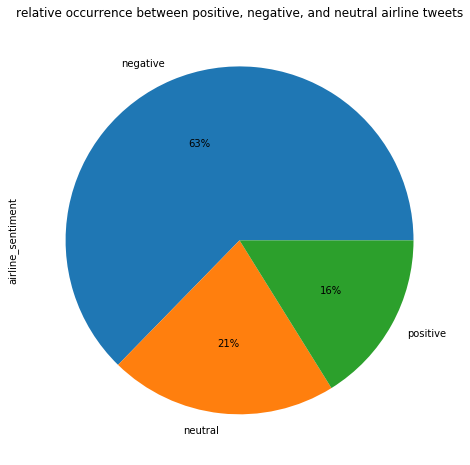

In [86]:
df['airline_sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.title('relative occurrence between positive, negative, and neutral airline tweets')
plt.show()

In [41]:
# most frequent words
words = vectorizer.get_feature_names()
a = np.argsort(np.sum(tdm.T, axis=1))[::-1][:30]
np.array(words)[a]

array(['united', 'flight', 'americanair', 'usairways', 'jetblue',
       'southwestair', 'thanks', 'thank', 'cancelled', 'just', 'service',
       'help', 'customer', 'time', 'im', 'hours', 'hold', 'flights',
       'virginamerica', 'plane', 'need', 'amp', 'delayed', 'flightled',
       'gate', 'dont', 'hour', 'bag', 'got', 'like'], dtype='<U20')

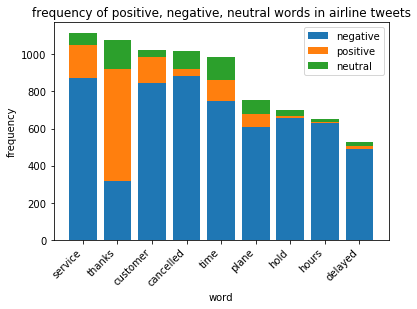

In [85]:
axis = ['service', 'thanks', 'customer', 'cancelled', 'time', 'plane', 'hold', 'hours', 'delayed']
pos_counts = []
neg_counts = []
neu_counts = []

for word in axis:
    pos_counts.append(df[df['airline_sentiment'] == 'positive']['text'].str.contains(word).value_counts()[True])
    neg_counts.append(df[df['airline_sentiment'] == 'negative']['text'].str.contains(word).value_counts()[True])
    neu_counts.append(df[df['airline_sentiment'] == 'neutral']['text'].str.contains(word).value_counts()[True])

pos_counts = np.array(pos_counts)
neg_counts = np.array(neg_counts)
neu_counts = np.array(neu_counts)
    
p1 = plt.bar(axis, neg_counts)
p2 = plt.bar(axis, pos_counts, bottom=neg_counts)
p3 = plt.bar(axis, neu_counts, bottom=pos_counts+neg_counts)

plt.xticks(rotation=45, ha="right")
plt.xlabel('word')
plt.ylabel('frequency')
plt.title('frequency of positive, negative, neutral words in airline tweets')
plt.legend((p1[0], p2[0], p3[0]), ('negative', 'positive', 'neutral'))
plt.show()

In [129]:
df.iloc[7]
# df['text'][7]
# df[df['airline_sentiment'] == 'neutral']

airline_sentiment                                              neutral
text                 virginamerica really missed a prime opportunit...
Name: 7, dtype: object

## Predicting with the model

In [130]:
sample_messages = ['all good now going to make it to boston on time im actually on your wifi right now', # positive
                   'it was ua381 on 14 feb point is overselling flights bad making people wait 1hr while you kick them off after boarding is worse', # negative
                   'what the hell flight 746 delayed since 3 pm finally boarded and now sitting on the tarmac is this fampampcking plane ever leaving',
                   'will you be making bosgtlas non stop permanently anytime soon', # neutral
                   'really missed a prime opportunity for men without hats parody there',
                  ]

test_message = 'all good now going to make it to boston on time im actually on your wifi right now'
# test_message = 'will you be making bosgtlas non stop permanently anytime soon'
# test_message = 'really missed a prime opportunity for men without hats parody there'
# test_message = ''

model.predict(vectorizer.transform(np.array([test_message])).toarray())[0]

'negative'